In [2]:
import pandas as pd
def evaluate_human_ranking(df: pd.DataFrame):
    expected_columns = ["dialogue", "validation", "faithfulness", "relevance", "icf_alignment"]
    for i, name in enumerate(expected_columns):
        if i < len(df.columns):
            df.columns.values[i] = name

    model_rows = df[df["dialogue"].str.contains(r"(?i)^model\d+", na=False)].copy()
    model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()
    model_rows["validation"] = model_rows["validation"].str.lower()

    def is_invalid(row, col_name):
        value = row[col_name]
        if pd.notna(value):
            return False
        if isinstance(row["validation"], str) and "invalid" in row["validation"]:
            return True
        return False

    model_rows["relevance_invalid"] = model_rows.apply(lambda row: is_invalid(row, "relevance"), axis=1)
    model_rows["icf_invalid"] = model_rows.apply(lambda row: is_invalid(row, "icf_alignment"), axis=1)

    def rank_distribution(series):
        return series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

    relevance_rank_dist = model_rows.groupby("model")["relevance"].apply(rank_distribution).unstack().add_prefix("rel_rank_")
    icf_rank_dist = model_rows.groupby("model")["icf_alignment"].apply(rank_distribution).unstack().add_prefix("icf_rank_")

    summary = model_rows.groupby("model").agg(
        valid_relevance_count=("relevance", lambda x: x.notna().sum()),
        invalid_relevance_count=("relevance_invalid", "sum"),
        avg_relevance_rank=("relevance", "mean"),
        valid_icf_count=("icf_alignment", lambda x: x.notna().sum()),
        invalid_icf_count=("icf_invalid", "sum"),
        avg_icf_rank=("icf_alignment", "mean")
    ).round(2)

    # 将排名分布合并并保留 model
    combined = pd.concat([summary, relevance_rank_dist, icf_rank_dist], axis=1).reset_index()  # ✅ model 作为显式列

    return combined


In [4]:
import os

# 设置包含你的 .tsv 文件的文件夹路径（请按实际路径修改）
data_dir = "human evaluation results"  # ← 修改为你自己的路径，比如 "./tsv_files"

# 获取所有 .tsv 文件列表
tsv_files = [f for f in os.listdir(data_dir) if f.endswith(".tsv")]

all_summaries = []
for filename in tsv_files:
    file_path = os.path.join(data_dir, filename)
    df = pd.read_csv(file_path, sep="\t")
    summary = evaluate_human_ranking(df)
    summary["file"] = filename
    all_summaries.append(summary)

combined_df = pd.concat(all_summaries, ignore_index=True)
print("列名检查：", combined_df.columns.tolist())  # ✅ 确保包含 'model'

# 最终 groupby 正常运行
overall_stats = combined_df.groupby("model").agg({
    "valid_relevance_count": "sum",
    "invalid_relevance_count": "sum",
    "avg_relevance_rank": "mean",
    "valid_icf_count": "sum",
    "invalid_icf_count": "sum",
    "avg_icf_rank": "mean",
    "rel_rank_1": "sum",
    "rel_rank_2": "sum",
    "rel_rank_3": "sum",
    "rel_rank_4": "sum",
    "rel_rank_5": "sum",
    "icf_rank_1": "sum",
    "icf_rank_2": "sum",
    "icf_rank_3": "sum",
    "icf_rank_4": "sum",
    "icf_rank_5": "sum",
}).round(2).reset_index()


列名检查： ['model', 'valid_relevance_count', 'invalid_relevance_count', 'avg_relevance_rank', 'valid_icf_count', 'invalid_icf_count', 'avg_icf_rank', 'rel_rank_1', 'rel_rank_2', 'rel_rank_3', 'rel_rank_4', 'rel_rank_5', 'icf_rank_1', 'icf_rank_2', 'icf_rank_3', 'icf_rank_4', 'icf_rank_5', 'file']


In [6]:
print(overall_stats)
overall_stats.to_csv("overall_human_eval_summary.csv", index=False)


    model  valid_relevance_count  invalid_relevance_count  avg_relevance_rank  \
0  model1                    314                        8                1.45   
1  model2                    314                        8                1.45   
2  model3                    293                       15                1.78   
3  model4                    297                       14                1.90   
4  model5                    300                       19                1.97   

   valid_icf_count  invalid_icf_count  avg_icf_rank  rel_rank_1  rel_rank_2  \
0              317                  6          1.96         236          37   
1              314                  8          2.03         235          40   
2              293                 15          2.71         177          47   
3              296                 15          2.74         170          37   
4              300                 19          2.82         172          38   

   rel_rank_3  rel_rank_4  rel_rank_5 

/var/folders/7p/lz8173z10t11n1drpgqzj1b40000gn/T/ipykernel_5211/1115524324.py:18: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7p/lz8173z10t11n1drpgqzj1b40000gn/T/ipykernel_5211/1115524324.py:18: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7p/lz8173z10t11n1drpgqzj1b40000gn/T/ipykernel_5211/1115524324.py:18: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7p/lz8173z10t11n1drpgqzj1b40000gn/T/ipykernel_5211/1115524324.py:18: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7p/lz8173z10t11n1drpgqzj1b40000gn/T/ipykernel_5211/1115524324.py:18: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7p/lz8173z10t11n1drpgqzj1b40000gn/T/ipyker

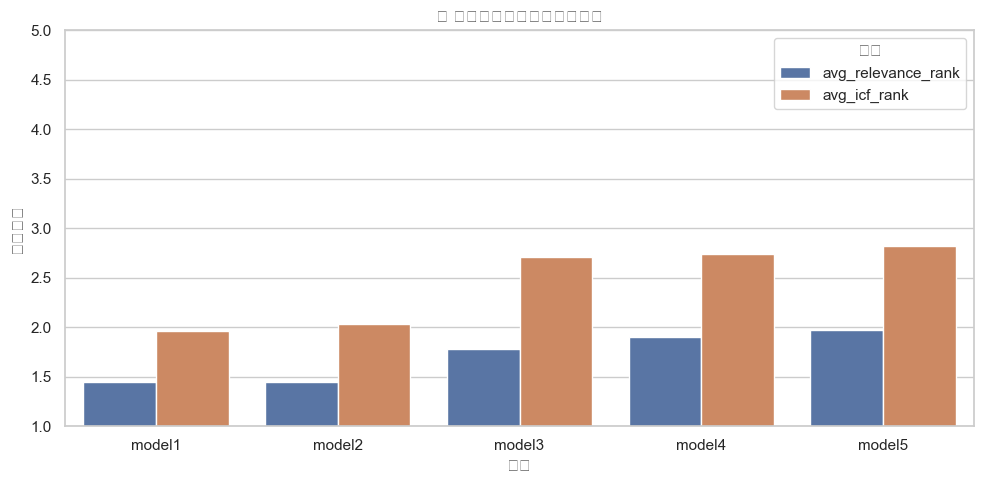

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# 设置风格
sns.set(style="whitegrid")

# 平均排名对比（relevance vs icf）
plt.figure(figsize=(10, 5))
avg_rank_data = overall_stats[["model", "avg_relevance_rank", "avg_icf_rank"]].melt(id_vars="model", 
                          var_name="Metric", value_name="Average Rank")
sns.barplot(data=avg_rank_data, x="model", y="Average Rank", hue="Metric")
plt.title("🔢 平均排名对比（越低越好）")
plt.ylim(1, 5)
plt.ylabel("平均排名")
plt.xlabel("模型")
plt.legend(title="指标")
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import os

def evaluate_human_ranking(df: pd.DataFrame):
    expected_columns = ["dialogue", "validation", "faithfulness", "relevance", "icf_alignment"]
    for i, name in enumerate(expected_columns):
        if i < len(df.columns):
            df.columns.values[i] = name

    model_rows = df[df["dialogue"].str.contains(r"(?i)^model\d+", na=False)].copy()
    model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()
    model_rows["validation"] = model_rows["validation"].str.lower()

    def is_invalid(row, col_name):
        value = row[col_name]
        if pd.notna(value):
            return False
        if isinstance(row["validation"], str) and "invalid" in row["validation"]:
            return True
        return False

    model_rows["relevance_invalid"] = model_rows.apply(lambda row: is_invalid(row, "relevance"), axis=1)
    model_rows["icf_invalid"] = model_rows.apply(lambda row: is_invalid(row, "icf_alignment"), axis=1)

    def rank_distribution(series):
        return series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

    relevance_rank_dist = model_rows.groupby("model")["relevance"].apply(rank_distribution).unstack().add_prefix("rel_rank_")
    icf_rank_dist = model_rows.groupby("model")["icf_alignment"].apply(rank_distribution).unstack().add_prefix("icf_rank_")

    summary = model_rows.groupby("model").agg(
        valid_relevance_count=("relevance", lambda x: x.notna().sum()),
        invalid_relevance_count=("relevance_invalid", "sum"),
        avg_relevance_rank=("relevance", "mean"),
        valid_icf_count=("icf_alignment", lambda x: x.notna().sum()),
        invalid_icf_count=("icf_invalid", "sum"),
        avg_icf_rank=("icf_alignment", "mean")
    ).round(2)

    # 合并排名分布
    combined = pd.concat([summary, relevance_rank_dist, icf_rank_dist], axis=1)

    # 添加 Top1 次数列
    combined["top1_rel_count"] = combined["rel_rank_1"]
    combined["top1_icf_count"] = combined["icf_rank_1"]

    # 添加无效比例列
    combined["rel_invalid_ratio"] = (combined["invalid_relevance_count"] / 
                                     (combined["valid_relevance_count"] + combined["invalid_relevance_count"])).round(2)
    combined["icf_invalid_ratio"] = (combined["invalid_icf_count"] / 
                                     (combined["valid_icf_count"] + combined["invalid_icf_count"])).round(2)

    return combined.reset_index()

# 主处理逻辑
data_dir = "human evaluation results"
tsv_files = [f for f in os.listdir(data_dir) if f.endswith(".tsv")]

all_summaries = []
for filename in tsv_files:
    file_path = os.path.join(data_dir, filename)
    df = pd.read_csv(file_path, sep="\t")
    summary = evaluate_human_ranking(df)
    summary["file"] = filename
    all_summaries.append(summary)

combined_df = pd.concat(all_summaries, ignore_index=True)

# 最终合并统计
overall_stats = combined_df.groupby("model").agg({
    "valid_relevance_count": "sum",
    "invalid_relevance_count": "sum",
    "rel_invalid_ratio": "mean",
    "avg_relevance_rank": "mean",
    "top1_rel_count": "sum",
    "valid_icf_count": "sum",
    "invalid_icf_count": "sum",
    "icf_invalid_ratio": "mean",
    "avg_icf_rank": "mean",
    "top1_icf_count": "sum",
    "rel_rank_1": "sum", "rel_rank_2": "sum", "rel_rank_3": "sum", "rel_rank_4": "sum", "rel_rank_5": "sum",
    "icf_rank_1": "sum", "icf_rank_2": "sum", "icf_rank_3": "sum", "icf_rank_4": "sum", "icf_rank_5": "sum"
}).round(2).reset_index()

# 输出结果
print(overall_stats)
overall_stats.to_csv("overall_human_eval_summary.csv", index=False)


    model  valid_relevance_count  invalid_relevance_count  rel_invalid_ratio  \
0  model1                    315                        8               0.02   
1  model2                    314                        8               0.02   
2  model3                    293                       15               0.05   
3  model4                    296                       15               0.05   
4  model5                    302                       19               0.06   

   avg_relevance_rank  top1_rel_count  valid_icf_count  invalid_icf_count  \
0                1.44             237              318                  6   
1                1.45             235              314                  8   
2                1.78             177              293                 15   
3                1.90             169              295                 16   
4                1.96             174              302                 19   

   icf_invalid_ratio  avg_icf_rank  ...  rel_rank_1  rel

In [8]:
combined_df = pd.concat(all_summaries, ignore_index=True)

# ✅ 对拼接结果再次 groupby 计算最终总表（每个模型一行）
final_stats = combined_df.groupby("model").agg({
    "avg_relevance_rank": "mean",
    "avg_icf_rank": "mean",
    "top1_rel_count": "sum",
    "top1_icf_count": "sum",
    "rel_invalid_ratio": "mean",
    "icf_invalid_ratio": "mean"
}).round(2).reset_index()

print(final_stats)


    model  avg_relevance_rank  avg_icf_rank  top1_rel_count  top1_icf_count  \
0  model1                1.45          1.96             236             181   
1  model2                1.45          2.03             235             181   
2  model3                1.78          2.71             177             117   
3  model4                1.90          2.74             170             114   
4  model5                1.97          2.82             172             120   

   rel_invalid_ratio  icf_invalid_ratio  
0               0.02               0.02  
1               0.02               0.02  
2               0.05               0.05  
3               0.04               0.05  
4               0.06               0.06  


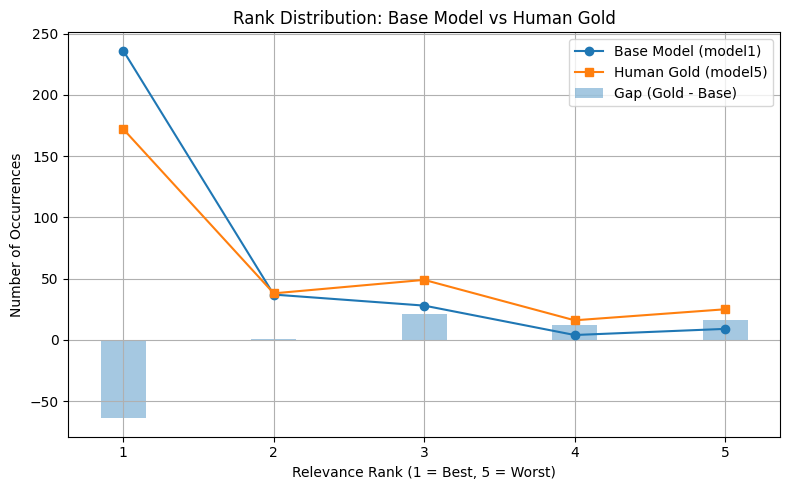

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载评估结果 CSV
overall_stats = pd.read_csv("overall_human_eval_summary.csv")

# 模型设定
base_model = "model1"
gold_model = "model5"
rank_cols = ["rel_rank_1", "rel_rank_2", "rel_rank_3", "rel_rank_4", "rel_rank_5"]
x = [1, 2, 3, 4, 5]

# 获取分布数据
base_values = overall_stats[overall_stats["model"] == base_model][rank_cols].values.flatten()
gold_values = overall_stats[overall_stats["model"] == gold_model][rank_cols].values.flatten()

# 计算 gap
gap = gold_values - base_values

# 画图
plt.figure(figsize=(8, 5))
plt.plot(x, base_values, marker="o", label=f"Base Model ({base_model})")
plt.plot(x, gold_values, marker="s", label=f"Human Gold ({gold_model})")
plt.bar(x, gap, width=0.3, alpha=0.4, label="Gap (Gold - Base)")

plt.xlabel("Relevance Rank (1 = Best, 5 = Worst)")
plt.ylabel("Number of Occurrences")
plt.title("Rank Distribution: Base Model vs Human Gold")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


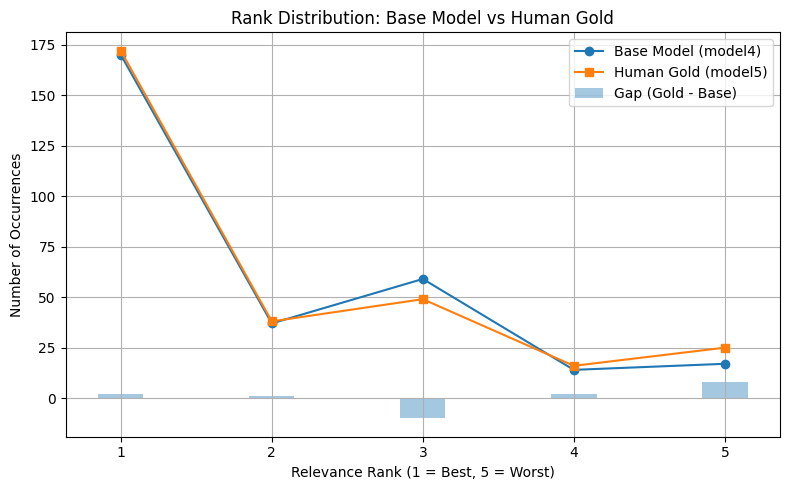

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载评估结果 CSV
overall_stats = pd.read_csv("overall_human_eval_summary.csv")

# 模型设定
base_model = "model4"
gold_model = "model5"
rank_cols = ["rel_rank_1", "rel_rank_2", "rel_rank_3", "rel_rank_4", "rel_rank_5"]
x = [1, 2, 3, 4, 5]

# 获取分布数据
base_values = overall_stats[overall_stats["model"] == base_model][rank_cols].values.flatten()
gold_values = overall_stats[overall_stats["model"] == gold_model][rank_cols].values.flatten()

# 计算 gap
gap = gold_values - base_values

# 画图
plt.figure(figsize=(8, 5))
plt.plot(x, base_values, marker="o", label=f"Base Model ({base_model})")
plt.plot(x, gold_values, marker="s", label=f"Human Gold ({gold_model})")
plt.bar(x, gap, width=0.3, alpha=0.4, label="Gap (Gold - Base)")

plt.xlabel("Relevance Rank (1 = Best, 5 = Worst)")
plt.ylabel("Number of Occurrences")
plt.title("Rank Distribution: Base Model vs Human Gold")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model4 和 model5 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model4 和 model5 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model4 和 model5 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model4 和 model5 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    141
1     58
2     47
3     16
4     19
dtype: int64


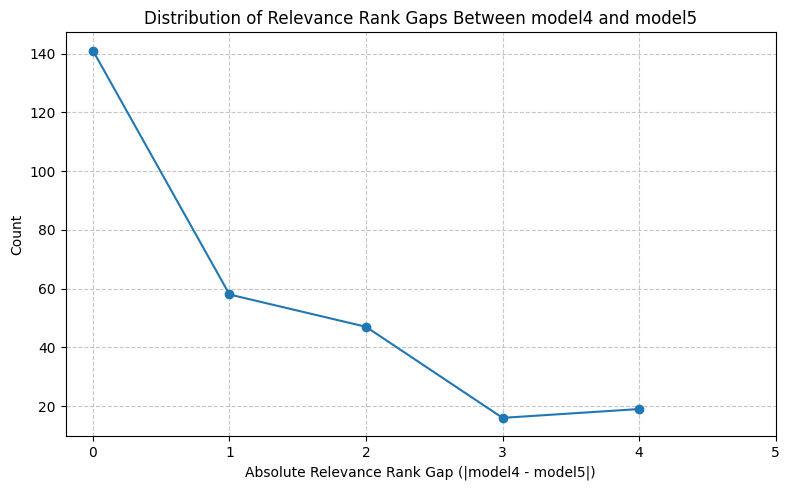

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略（仅匹配是否含有 model4 和 model5，不考虑分数）
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "relevance" in name and "relevance" not in used_names:
                rename_map[col] = "relevance"
                used_names.add("relevance")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "relevance" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["relevance"] = pd.to_numeric(df["relevance"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model4" in models_in_block and "model5" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r4 = block[block["model"] == "model4"]["relevance"].dropna()
                r5 = block[block["model"] == "model5"]["relevance"].dropna()
                if not r4.empty and not r5.empty:
                    gap = abs(r4.values[0] - r5.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model4 和 model5 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute Relevance Rank Gap (|model4 - model5|)")
    plt.ylabel("Count")
    plt.title("Distribution of Relevance Rank Gaps Between model4 and model5")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model1 和 model5 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model1 和 model5 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model1 和 model5 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model1 和 model5 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    146
1     54
2     57
3     20
4     19
dtype: int64


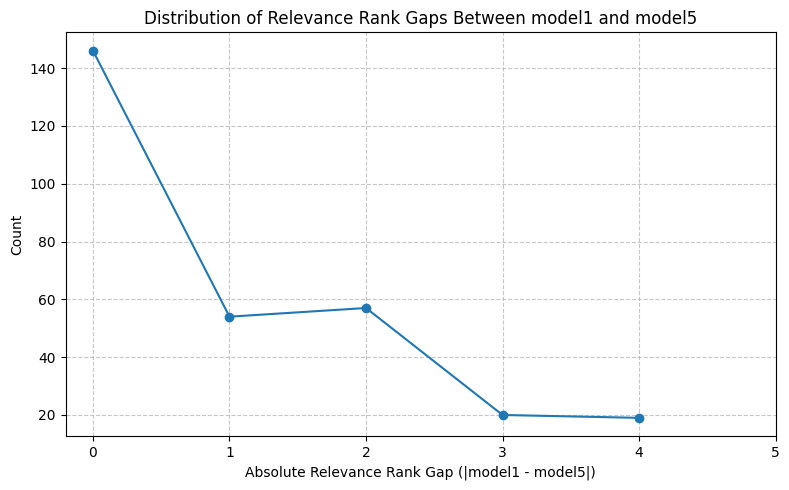

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略（仅匹配是否含有 model1 和 model5，不考虑分数）
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "relevance" in name and "relevance" not in used_names:
                rename_map[col] = "relevance"
                used_names.add("relevance")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "relevance" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["relevance"] = pd.to_numeric(df["relevance"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model1" in models_in_block and "model5" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r1 = block[block["model"] == "model1"]["relevance"].dropna()
                r5 = block[block["model"] == "model5"]["relevance"].dropna()
                if not r1.empty and not r5.empty:
                    gap = abs(r1.values[0] - r5.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model1 和 model5 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute Relevance Rank Gap (|model1 - model5|)")
    plt.ylabel("Count")
    plt.title("Distribution of Relevance Rank Gaps Between model1 and model5")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model3 和 model5 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model3 和 model5 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model3 和 model5 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model3 和 model5 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    133
1     57
2     55
3     14
4     16
dtype: int64


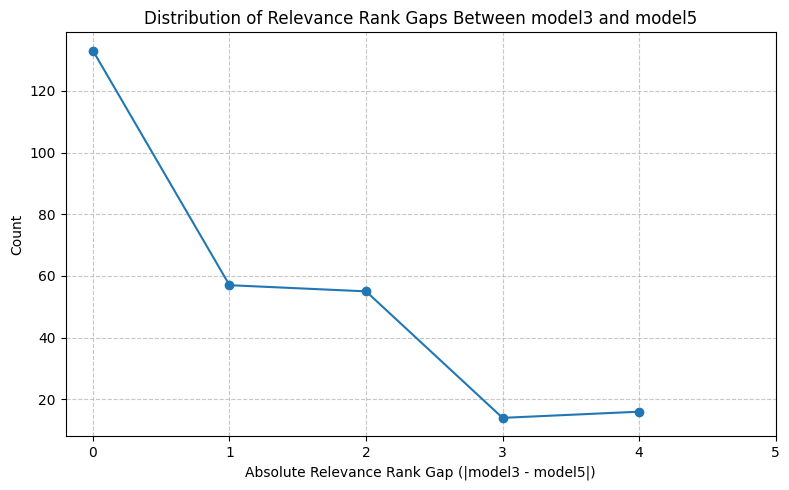

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略（仅匹配是否含有 model3 和 model5，不考虑分数）
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "relevance" in name and "relevance" not in used_names:
                rename_map[col] = "relevance"
                used_names.add("relevance")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "relevance" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["relevance"] = pd.to_numeric(df["relevance"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model3" in models_in_block and "model5" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r3 = block[block["model"] == "model3"]["relevance"].dropna()
                r5 = block[block["model"] == "model5"]["relevance"].dropna()
                if not r3.empty and not r5.empty:
                    gap = abs(r3.values[0] - r5.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model3 和 model5 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute Relevance Rank Gap (|model3 - model5|)")
    plt.ylabel("Count")
    plt.title("Distribution of Relevance Rank Gaps Between model3 and model5")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model3 和 model5 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model3 和 model5 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model3 和 model5 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model3 和 model5 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    121
1     47
2     58
3     12
4     37
dtype: int64


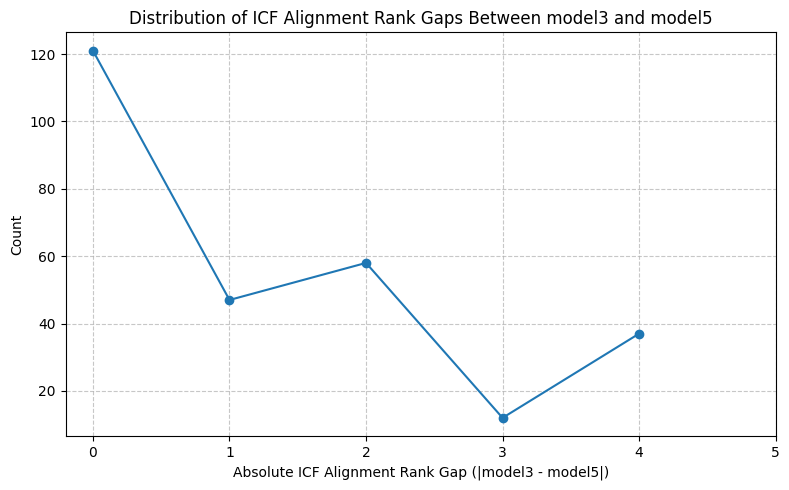

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略（仅匹配是否含有 model3 和 model5，不考虑其他模型）
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "icf alignment" in name and "icf_alignment" not in used_names:
                rename_map[col] = "icf_alignment"
                used_names.add("icf_alignment")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "icf_alignment" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["icf_alignment"] = pd.to_numeric(df["icf_alignment"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model3" in models_in_block and "model5" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r3 = block[block["model"] == "model3"]["icf_alignment"].dropna()
                r5 = block[block["model"] == "model5"]["icf_alignment"].dropna()
                if not r3.empty and not r5.empty:
                    gap = abs(r3.values[0] - r5.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model3 和 model5 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute ICF Alignment Rank Gap (|model3 - model5|)")
    plt.ylabel("Count")
    plt.title("Distribution of ICF Alignment Rank Gaps Between model3 and model5")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model4 和 model5 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model4 和 model5 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model4 和 model5 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model4 和 model5 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    137
1     39
2     50
3     14
4     40
dtype: int64


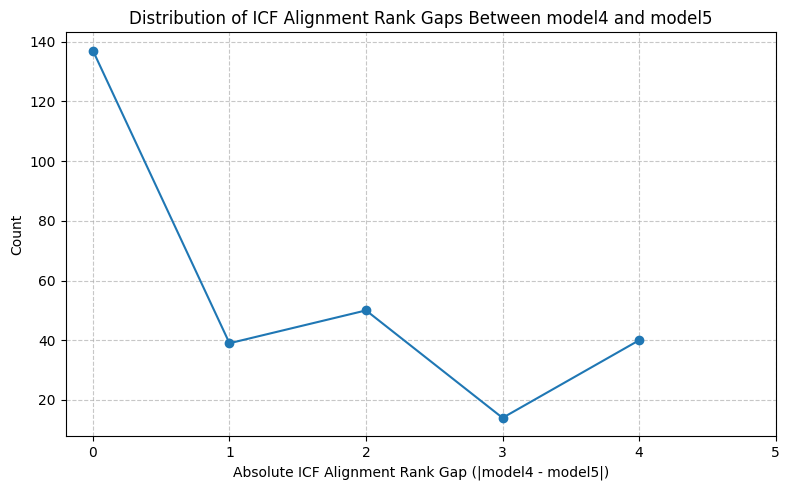

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略（仅匹配是否含有 model4 和 model5，不考虑其他模型）
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "icf alignment" in name and "icf_alignment" not in used_names:
                rename_map[col] = "icf_alignment"
                used_names.add("icf_alignment")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "icf_alignment" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["icf_alignment"] = pd.to_numeric(df["icf_alignment"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model4" in models_in_block and "model5" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r4 = block[block["model"] == "model4"]["icf_alignment"].dropna()
                r5 = block[block["model"] == "model5"]["icf_alignment"].dropna()
                if not r4.empty and not r5.empty:
                    gap = abs(r4.values[0] - r5.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model4 和 model5 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute ICF Alignment Rank Gap (|model4 - model5|)")
    plt.ylabel("Count")
    plt.title("Distribution of ICF Alignment Rank Gaps Between model4 and model5")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model1 和 model5 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model1 和 model5 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model1 和 model5 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model1 和 model5 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    113
1     44
2     65
3     25
4     51
dtype: int64


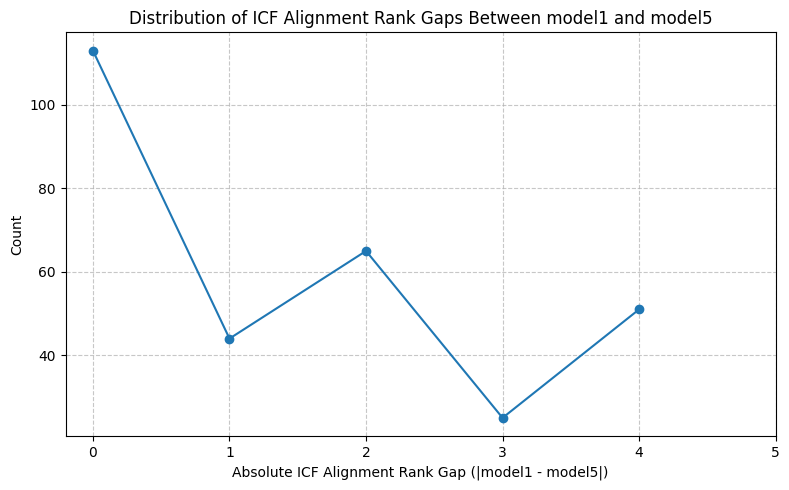

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略（仅匹配是否含有 model1 和 model5，不考虑其他模型）
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "icf alignment" in name and "icf_alignment" not in used_names:
                rename_map[col] = "icf_alignment"
                used_names.add("icf_alignment")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "icf_alignment" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["icf_alignment"] = pd.to_numeric(df["icf_alignment"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model1" in models_in_block and "model5" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r1 = block[block["model"] == "model1"]["icf_alignment"].dropna()
                r5 = block[block["model"] == "model5"]["icf_alignment"].dropna()
                if not r1.empty and not r5.empty:
                    gap = abs(r1.values[0] - r5.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model1 和 model5 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute ICF Alignment Rank Gap (|model1 - model5|)")
    plt.ylabel("Count")
    plt.title("Distribution of ICF Alignment Rank Gaps Between model1 and model5")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model1 和 model4 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model1 和 model4 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model1 和 model4 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model1 和 model4 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    127
1     53
2     53
3     18
4     42
dtype: int64


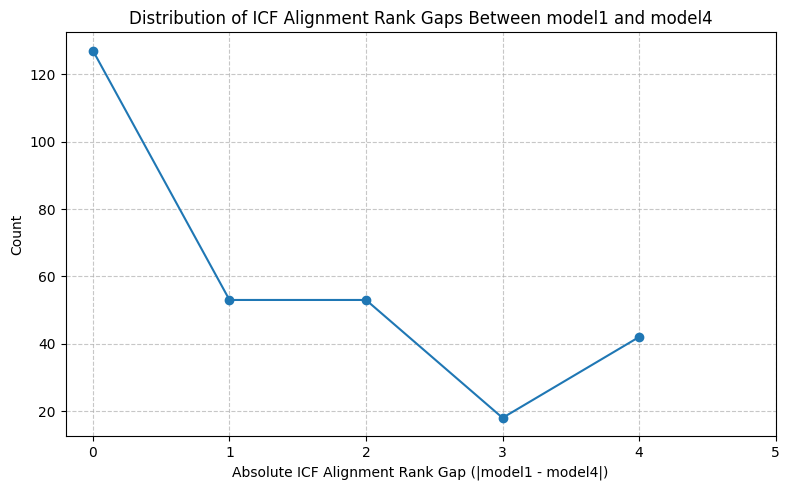

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略：匹配 model1 和 model4，不考虑其他模型
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "icf alignment" in name and "icf_alignment" not in used_names:
                rename_map[col] = "icf_alignment"
                used_names.add("icf_alignment")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "icf_alignment" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["icf_alignment"] = pd.to_numeric(df["icf_alignment"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model1" in models_in_block and "model4" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r1 = block[block["model"] == "model1"]["icf_alignment"].dropna()
                r4 = block[block["model"] == "model4"]["icf_alignment"].dropna()
                if not r1.empty and not r4.empty:
                    gap = abs(r1.values[0] - r4.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model1 和 model4 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute ICF Alignment Rank Gap (|model1 - model4|)")
    plt.ylabel("Count")
    plt.title("Distribution of ICF Alignment Rank Gaps Between model1 and model4")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")



📄 处理文件: Human evaluation template - D445.tsv
原始列数: 8
✅ 成功匹配 model1 和 model4 的组块: 83 / 83（未匹配: 0）

📄 处理文件: Human evaluation template - D420.tsv
原始列数: 7
✅ 成功匹配 model1 和 model4 的组块: 77 / 77（未匹配: 0）

📄 处理文件: Human evaluation template - D465.tsv
原始列数: 8
✅ 成功匹配 model1 和 model4 的组块: 97 / 97（未匹配: 0）

📄 处理文件: Human evaluation template - D470.tsv
原始列数: 6
✅ 成功匹配 model1 和 model4 的组块: 90 / 90（未匹配: 0）

📊 所有文件总匹配情况：成功 347 / 347（未匹配 0）

📊 gap 值分布：
0    153
1     51
2     57
3     13
4     17
dtype: int64


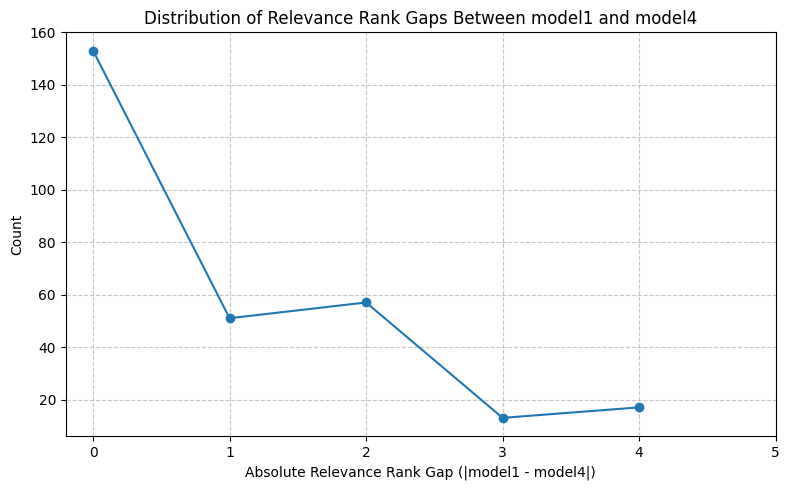

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 最大宽松策略：匹配 model1 和 model4，不考虑其他模型
data_dir = "human evaluation results"
matched_blocks_count = 0
total_blocks_count = 0
all_gaps = []
unmatched_blocks = []

for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        print(f"\n📄 处理文件: {filename}")
        print("原始列数:", df.shape[1])

        # 自动识别并重命名列
        rename_map = {}
        used_names = set()
        for col in df.columns:
            name = col.lower()
            if "dialogue" in name and "dialogue" not in used_names:
                rename_map[col] = "dialogue"
                used_names.add("dialogue")
            elif "relevance" in name and "relevance" not in used_names:
                rename_map[col] = "relevance"
                used_names.add("relevance")

        df = df.rename(columns=rename_map)
        if "dialogue" not in df.columns or "relevance" not in df.columns:
            print("❌ 缺少必要列，跳过该文件。")
            continue

        df["dialogue"] = df["dialogue"].fillna("")
        df["relevance"] = pd.to_numeric(df["relevance"], errors="coerce")
        model_rows = df[df["dialogue"].str.lower().str.startswith("model")].copy()
        model_rows["model"] = model_rows["dialogue"].str.extract(r"(?i)(model\d+)")[0].str.lower()

        success_count = 0
        total_windows = 0
        window_size = 5
        used_indices = set()
        file_unmatched = []

        for i in range(0, len(model_rows) - window_size + 1):
            if any(j in used_indices for j in range(i, i + window_size)):
                continue

            block = model_rows.iloc[i:i + window_size]
            models_in_block = set(block["model"].dropna().unique())

            if "model1" in models_in_block and "model4" in models_in_block:
                used_indices.update(range(i, i + window_size))
                r1 = block[block["model"] == "model1"]["relevance"].dropna()
                r4 = block[block["model"] == "model4"]["relevance"].dropna()
                if not r1.empty and not r4.empty:
                    gap = abs(r1.values[0] - r4.values[0])
                    all_gaps.append(int(gap))
                success_count += 1
            else:
                file_unmatched.append(block["dialogue"].tolist())

            total_windows += 1

        unmatched_blocks.append((filename, file_unmatched))
        matched_blocks_count += success_count
        total_blocks_count += total_windows
        print(f"✅ 成功匹配 model1 和 model4 的组块: {success_count} / {total_windows}（未匹配: {total_windows - success_count}）")

# 输出总数
print(f"\n📊 所有文件总匹配情况：成功 {matched_blocks_count} / {total_blocks_count}（未匹配 {total_blocks_count - matched_blocks_count}）")

# 打印未匹配内容
for fname, blocks in unmatched_blocks:
    if blocks:
        print(f"\n❌ 未匹配块 - 文件: {fname}")
        for idx, block in enumerate(blocks, 1):
            print(f" Block {idx}:")
            for line in block:
                print(f"   {line}")
            print()

# 画出 gap 分布图
if all_gaps:
    gap_counts = Counter(all_gaps)
    gap_series = pd.Series(gap_counts).sort_index()

    print("\n📊 gap 值分布：")
    print(gap_series)

    plt.figure(figsize=(8, 5))
    plt.plot(gap_series.index, gap_series.values, marker='o', linestyle='-')
    plt.xlabel("Absolute Relevance Rank Gap (|model1 - model4|)")
    plt.ylabel("Count")
    plt.title("Distribution of Relevance Rank Gaps Between model1 and model4")
    plt.xticks(range(0, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有可计算 gap 的配对。")
